In [1]:
import os,sys,signal, copy
import math
from contextlib import contextmanager

import pickle
import numpy as np                                       # fast vectors and matrices
import matplotlib.pyplot as plt                          # plotting
import matplotlib.ticker as ticker
from matplotlib.animation import ArtistAnimation

from scipy.fftpack import fft
from scipy.signal.windows import hann

import musicnetRaven as musicnet

from time import time

sys.path.insert(0,'lib/')
import config
import diagnosticsP3
# import base_model

from sklearn.metrics import average_precision_score

os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'   # see issue #152
os.environ['CUDA_VISIBLE_DEVICES']='1'

import torch
from torch.nn.functional import conv1d, mse_loss
from torchcontrib.optim import SWA

from tqdm import tqdm
import mir_eval

from pypianoroll import Multitrack, Track, load, parse
from pypianoroll import Multitrack, Track, load, parse

%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
def export_midi(Y_pred, path):
    # Create a piano-roll matrix, where the first and second axes represent time
    # and pitch, respectively, and assign a C major chord to the piano-roll
    # Create a `pypianoroll.Track` instance
    track = Track(pianoroll=Y_pred*127, program=0, is_drum=False,
                  name='my awesome piano')   
    multitrack = Multitrack(tracks=[track], tempo=120.0, beat_resolution=24)
    multitrack.write(path)

In [25]:
from scipy import load

In [ ]:
load('')

In [4]:
def get_piano_roll(rec_id, window=16384, stride=1000, offset=44100, count=7500):
    sf=4
    if stride == -1:
        stride = (test_set.records[rec_id][1] - offset - int(sf*window))/(count-1)
        stride = int(stride)
    else:
        count = (test_set.records[rec_id][1] - offset - int(sf*window))/stride + 1
        count = int(count)
        
    X = np.zeros([count, window])
    Y = np.zeros([count, m])    
        
    for i in range(count):
        print(f"Transcribing {i}/{count} batches", end = '\r')
        X[i,:], Y[i] =  test_set.access(rec_id, offset+i*stride)
        
    X = torch.tensor(X).float().cuda()
    Y_pred = model(X)
    
    return Y_pred, Y
def get_mir_accuracy(Yhat, Y_true, threshold=0.4):
    Yhatlist = []
    Ylist = []
    Yhatpred = Yhat>threshold
    for i in range(len(Yhatpred)):
        print(f"Evaluating {i}/{len(Yhatpred)} batches", end = '\r')
        fhat = []
        f = []
        for note in range(m):
            if Yhatpred[i][note] == 1:
                fhat.append(440.*2**(((note)-69.)/12.))

            if Y_true[i][note] == 1:
                f.append(440.*2**(((note)-69.)/12.))

        Yhatlist.append(np.array(fhat))
        Ylist.append(np.array(f))
    avp = average_precision_score(Y_true.flatten(),Yhat.detach().cpu().flatten())
    P,R,Acc,Esub,Emiss,Efa,Etot,cP,cR,cAcc,cEsub,cEmiss,cEfa,cEtot = \
    mir_eval.multipitch.metrics(np.arange(len(Ylist))/100.,Ylist,np.arange(len(Yhatlist))/100.,Yhatlist)
    print('{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}'.format(100*avp,100*P,100*R,Acc,Etot,Esub,Emiss,Efa))
    return avp,P,R,Acc,Etot    

In [5]:
# function for returning scientific notation in a plot
def fmt(x, pos):
    a, b = '{:.0e}'.format(x).split('e')
    b = int(b)
    return fr'${a} \times 10^{{{b}}}$'

In [6]:
# lvl1 convolutions are shared between regions
m = 128
k = 500              # lvl1 nodes
n_fft = 4096              # lvl1 receptive field
window = 16384 # total number of audio samples?
stride = 512
batch_size = 500
regions = 1 + (window - n_fft)//stride

def worker_init(args):
    signal.signal(signal.SIGINT, signal.SIG_IGN) # ignore signals so parent can handle them
    np.random.seed(os.getpid() ^ int(time())) # approximately random seed for workers
kwargs = {'num_workers': 15, 'pin_memory': True, 'worker_init_fn': worker_init}

In [7]:
start = time()
root = '../data/'
test_set = musicnet.MusicNet(root=root, train=False, download=True, refresh_cache=False, window=window, epoch_size=50000, mmap=False)
print("Time used = ", time()-start)

Time used =  0.7287013530731201


In [8]:
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,**kwargs)

In [9]:
with test_set:
    print(test_set.records)

{2106: ('../data/test_data/2106.bin', 9995520.0), 2628: ('../data/test_data/2628.bin', 5498496.0), 2191: ('../data/test_data/2191.bin', 4535424.0), 2303: ('../data/test_data/2303.bin', 4086144.0), 1819: ('../data/test_data/1819.bin', 7826688.0), 2298: ('../data/test_data/2298.bin', 6770304.0), 2382: ('../data/test_data/2382.bin', 5203584.0), 2416: ('../data/test_data/2416.bin', 6135552.0), 2556: ('../data/test_data/2556.bin', 6679296.0), 1759: ('../data/test_data/1759.bin', 8584704.0)}


In [10]:
def create_filters(n_fft, freq_bins=None, low=50,high=6000, mode="fft"):
    if freq_bins==None:
        freq_bins = n_fft//2+1
    
    s = np.arange(0, n_fft, 1)
    wsin = np.empty((freq_bins,1,n_fft), dtype=np.float32)
    wcos = np.empty((freq_bins,1,n_fft), dtype=np.float32)
    start_freq = low
    end_freq = high
    # num_cycles = start_freq*d/44000.
    # scaling_ind = np.log(end_freq/start_freq)/k
    
    if mode=="fft":
        window_mask = 1
    elif mode=="stft":
        window_mask = hann(n_fft, sym=False) # same as 0.5-0.5*np.cos(2*np.pi*x/(k))
    else:
        raise Exception("Unknown mode, please chooes either \"stft\" or \"fft\"")
        

    for k in range(freq_bins): # Only half of the bins contain useful info
        wsin[k,0,:] = window_mask*np.sin(2*np.pi*k*s/n_fft)
        wcos[k,0,:] = window_mask*np.cos(2*np.pi*k*s/n_fft)
    
    return wsin,wcos

def create_filtersv2(n_fft, freq_bins=None, low=50,high=6000, mode="fft"):
    if freq_bins==None:
        freq_bins = n_fft//2+1
    
    s = torch.arange(0, n_fft, 1.)
    wsin = torch.empty((freq_bins,1,n_fft))
    wcos = torch.empty((freq_bins,1,n_fft))
    start_freq = low
    end_freq = high
    # num_cycles = start_freq*d/44000.
    # scaling_ind = np.log(end_freq/start_freq)/k
    
    if mode=="fft":
        window_mask = 1
    elif mode=="stft":
        window_mask = 0.5-0.5*torch.cos(2*math.pi*s/(n_fft)) # same as hann(n_fft, sym=False)
    else:
        raise Exception("Unknown mode, please chooes either \"stft\" or \"fft\"")
        

    for k in range(freq_bins): # Only half of the bins contain useful info
        wsin[k,0,:] = window_mask*torch.sin(2*math.pi*k*s/n_fft)
        wcos[k,0,:] = window_mask*torch.cos(2*math.pi*k*s/n_fft)
    
    return wsin,wcos


In [11]:
Loss = torch.nn.MSELoss()
def L(yhatvar,y):
    return Loss(yhatvar,y) * 128/2

In [12]:
class Model(torch.nn.Module):
    def __init__(self, avg=.9998):
        super(Model, self).__init__()
        # Create filter windows
        wsin, wcos = create_filtersv2(n_fft,k, mode="stft")
        with torch.cuda.device(0):
            self.wsin = torch.Tensor(wsin).cuda()
            self.wcos = torch.Tensor(wcos).cuda()
            
        # Creating Layers
        self.linear = torch.nn.Linear(regions*k, m)
        torch.nn.init.constant_(self.linear.weight, 0) # initialize
        
        self.avg = avg
        #Create a container for weight average
        self.averages = copy.deepcopy(list(parm.cuda().data for parm in self.parameters())) 

        
    def forward(self,x):
        zx = conv1d(x[:,None,:], self.wsin, stride=stride).pow(2) \
           + conv1d(x[:,None,:], self.wcos, stride=stride).pow(2)
        return self.linear(torch.log(zx + 10e-8).view(x.data.size()[0],regions*k))
    
    def average_iterates(self):
        for parm, pavg in zip(self.parameters(), self.averages):
            pavg.mul_(self.avg).add_(1.-self.avg, parm.data) # 0.9W_avg + 0.1W_this_ite
    
    
@contextmanager
def averages(model):
    orig_parms = copy.deepcopy(list(parm.data for parm in model.parameters()))
    for parm, pavg in zip(model.parameters(), model.averages):
        parm.data.copy_(pavg)
    yield
    for parm, orig in zip(model.parameters(), orig_parms):
        parm.data.copy_(orig)

# Averaged Weights

In [13]:
model = Model()
model.cuda()


Model(
  (linear): Linear(in_features=12500, out_features=128, bias=True)
)

In [14]:
model.load_state_dict(torch.load('./weights/Toy_weight'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [15]:
print('AvgP\tP\tR\tAcc\tETot\tESub\tEmiss\tEfa')
with test_set:
    for songid in [1759]:
        model.eval()
        Y_pred, Y_true = get_piano_roll(songid, stride=-1)
    #     Yhatpred = Y_pred > 0.4
        _,_,_,Acc,Etot = get_mir_accuracy(Y_pred, Y_true)

AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
67.91	69.78	60.89	0.48	0.52	0.13	0.26	0.13


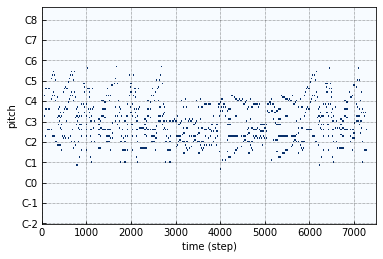

In [16]:
# Create a piano-roll matrix, where the first and second axes represent time
# and pitch, respectively, and assign a C major chord to the piano-roll
# Create a `pypianoroll.Track` instance
track = Track(pianoroll=Y_true*127, program=0, is_drum=False,
              name='my awesome piano')

# Plot the piano-roll
fig, ax = track.plot()

In [22]:
Yhatpred = Y_pred > 0.4

In [23]:
Yhatpred = Yhatpred.cpu().numpy()

In [17]:
def export_midi(Y_pred, path):
    # Create a piano-roll matrix, where the first and second axes represent time
    # and pitch, respectively, and assign a C major chord to the piano-roll
    # Create a `pypianoroll.Track` instance
    track = Track(pianoroll=Y_pred*127, program=0, is_drum=False,
                  name='my awesome piano')   
    multitrack = Multitrack(tracks=[track], tempo=120.0, beat_resolution=24)
    multitrack.write(path)

In [24]:
export_midi(Y_true, './Y_true.mid')
export_midi(Yhatpred, './Y_pred.mid')